In [ ]:
import sys
from pathlib import Path

root = Path.cwd()
for _ in range(6):
	if (root / 'workspace').exists():
		sys.path.insert(0, str(root))
		break
	if root.parent == root:
		break
	root = root.parent
 
from dataclasses import dataclass
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
from tqdm import tqdm
import gymnasium as gym

from workspace.utils.training_config_tabular import TrainingConfigTabular
from workspace.utils.training_config_dqn import TrainingConfigDQN
from workspace.agents.time_diff import TDAgent
from workspace.agents.monte_carlo import MonteCarloAgent
from workspace.agents.monte_carlo_es import MonteCarloESAgent
from workspace.agents.dqn import DQNAgent

In [49]:
def make_env(num_episodes):
    env = gym.make("Blackjack-v1", sab=True)
    return gym.wrappers.RecordEpisodeStatistics(env, buffer_length=num_episodes)

In [50]:
def train_agent(env, agent, cfg):
    for _ in tqdm(range(cfg.n_episodes), desc=f"Training {agent.__class__.__name__}"):
        obs, _ = env.reset()
        done = False
        while not done:
            action = agent.get_action(obs)
            next_obs, reward, terminated, truncated, _ = env.step(action)
            agent.update(obs, action, reward, terminated, next_obs)
            obs = next_obs
            done = terminated or truncated
        agent.decay_epsilon()

In [51]:
def moving_average(x, window, mode="same"):
    return np.convolve(x, np.ones(window), mode=mode) / window

In [52]:
def plot_training(env, agent, rolling_length=1000):
    fig, axs = plt.subplots(ncols=3, figsize=(12, 5))
    axs[0].set_title("Episode rewards")
    rewards = np.array(env.return_queue).flatten()
    axs[0].plot(moving_average(rewards, rolling_length, mode="valid"))

    axs[1].set_title("Episode lengths")
    lengths = np.array(env.length_queue).flatten()
    axs[1].plot(moving_average(lengths, rolling_length, mode="same"))

    axs[2].set_title("Training Error")
    errs = np.array(agent.training_error)
    axs[2].plot(moving_average(errs, rolling_length, mode="same"))

    plt.tight_layout()
    plt.show()

In [53]:
def create_grids(agent, usable_ace=False):
    state_value = defaultdict(float)
    policy = defaultdict(int)
    for obs, action_values in agent.q_values.items():
        state_value[obs] = float(np.max(action_values))
        policy[obs] = int(np.argmax(action_values))

    player_count, dealer_count = np.meshgrid(np.arange(12, 22), np.arange(1, 11))

    value = np.apply_along_axis(
        lambda o: state_value[(int(o[0]), int(o[1]), usable_ace)],
        axis=2,
        arr=np.dstack([player_count, dealer_count]),
    )

    policy_grid = np.apply_along_axis(
        lambda o: policy[(int(o[0]), int(o[1]), usable_ace)],
        axis=2,
        arr=np.dstack([player_count, dealer_count]),
    )

    return (player_count, dealer_count, value), policy_grid

In [54]:
def create_plots(value_grid, policy_grid, title: str):
    player_count, dealer_count, value = value_grid
    fig = plt.figure(figsize=plt.figaspect(0.4))
    fig.suptitle(title, fontsize=16)

    ax1 = fig.add_subplot(1, 2, 1, projection="3d")
    ax1.plot_surface(player_count, dealer_count, value, rstride=1, cstride=1, cmap="viridis", edgecolor="none")
    ax1.set_title(f"State values: {title}")
    ax1.set_xlabel("Player sum")
    ax1.set_ylabel("Dealer showing")
    ax1.zaxis.set_rotate_label(False)
    ax1.set_zlabel("Value", fontsize=14, rotation=90)
    ax1.view_init(20, 220)

    ax2 = fig.add_subplot(1, 2, 2)
    sns.heatmap(policy_grid, linewidth=0, annot=True, cmap="Accent_r", cbar=False, ax=ax2)
    ax2.set_title(f"Policy: {title}")
    ax2.set_xlabel("Player sum")
    ax2.set_ylabel("Dealer showing")
    ax2.set_xticklabels(range(12, 22))
    ax2.set_yticklabels(["A"] + list(range(2, 11)), fontsize=12)

    legend_elements = [
        Patch(facecolor="lightgreen", edgecolor="black", label="Hit"),
        Patch(facecolor="grey", edgecolor="black", label="Stick"),
    ]
    ax2.legend(handles=legend_elements, bbox_to_anchor=(1.3, 1))
    return fig

In [55]:
cfg = TrainingConfigTabular()
cfg_dqn = TrainingConfigDQN()
env = make_env(cfg.n_episodes)

In [56]:
agents = [
    TDAgent(action_n=env.action_space.n, cfg=cfg),
    MonteCarloAgent(action_n=env.action_space.n, cfg=cfg),
    MonteCarloESAgent(action_n=env.action_space.n, cfg=cfg),
    DQNAgent(action_n=env.action_space.n, cfg=cfg_dqn),
]


Entrenando agente 1/4: TDAgent


Training TDAgent: 100%|██████████| 300000/300000 [00:34<00:00, 8662.86it/s]



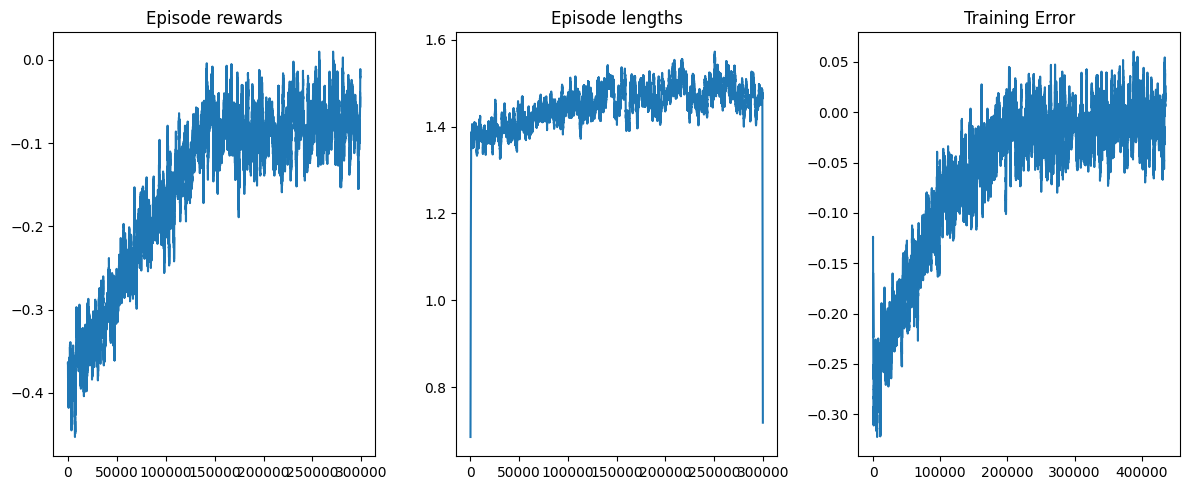

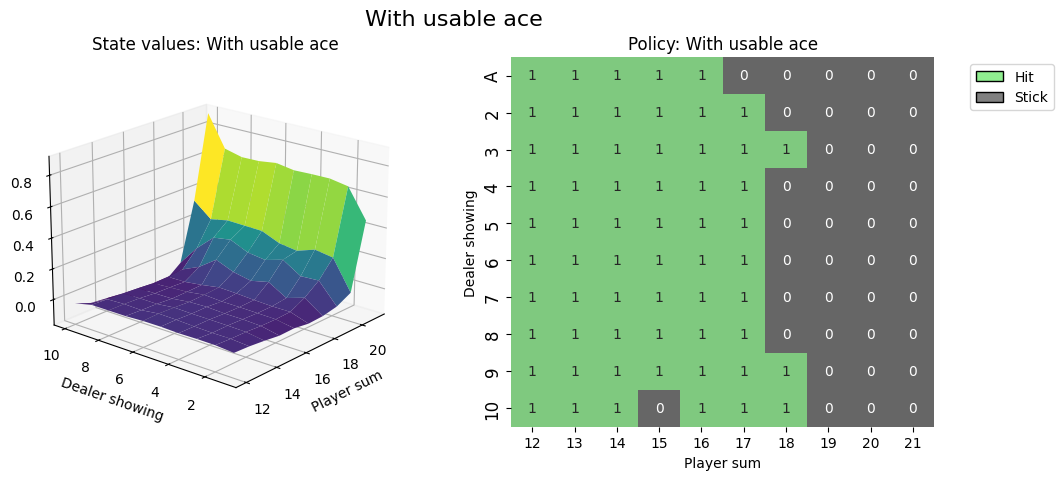

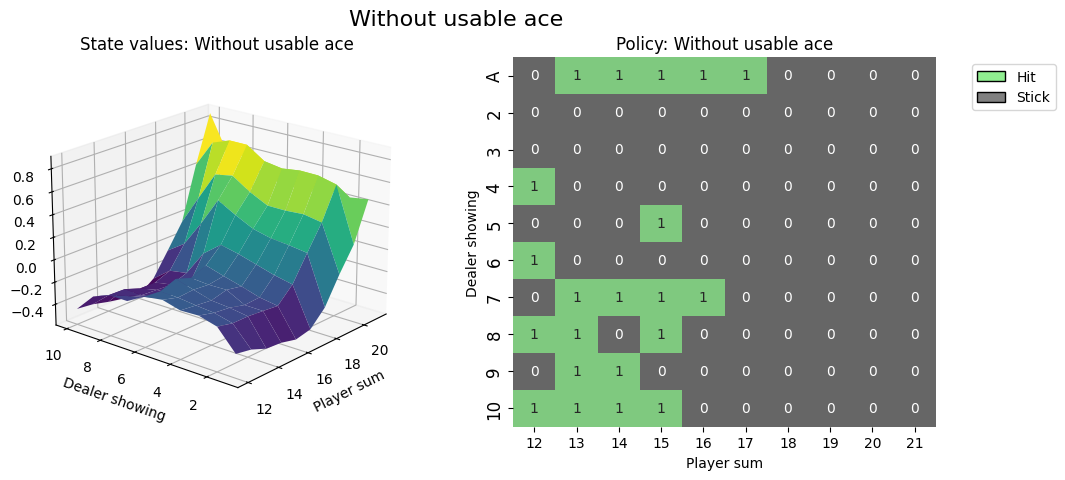


Entrenando agente 2/4: MonteCarloAgent


Training MonteCarloAgent: 100%|██████████| 300000/300000 [00:32<00:00, 9259.65it/s]



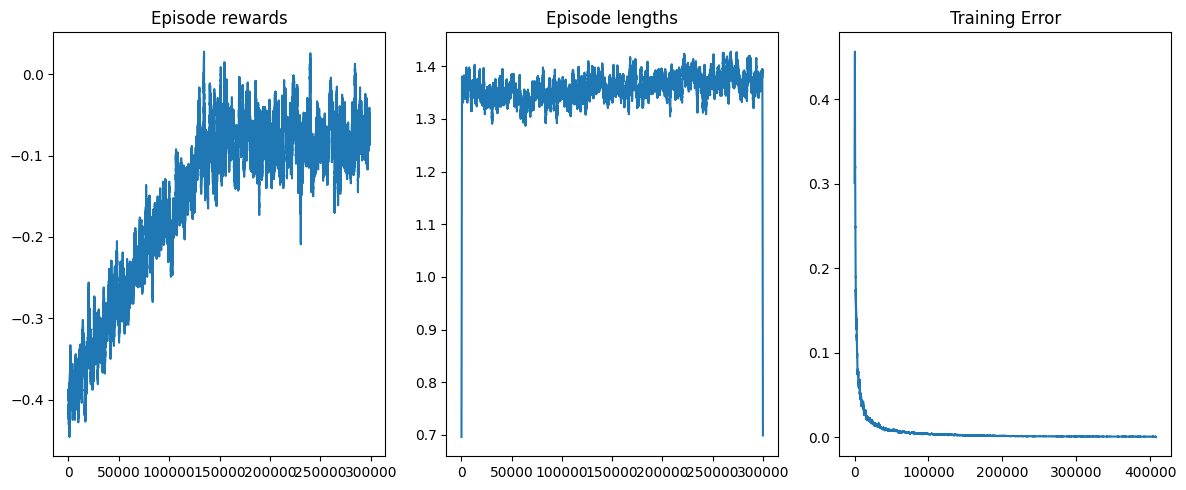

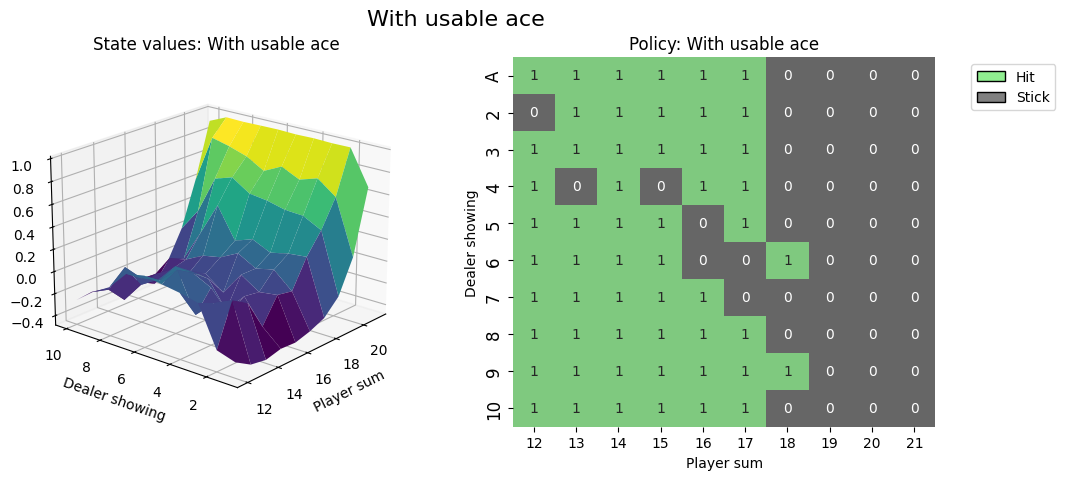

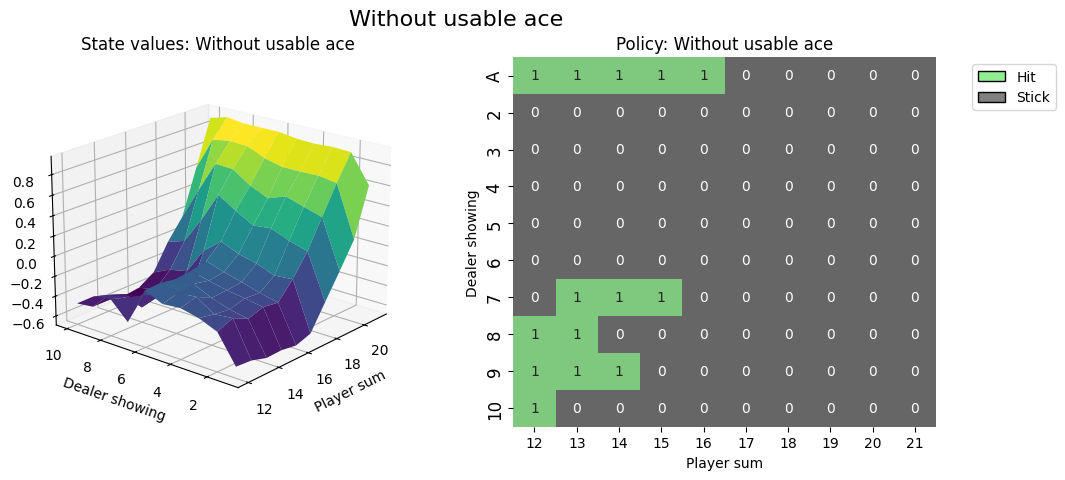


Entrenando agente 3/4: MonteCarloESAgent


Training MonteCarloESAgent: 100%|██████████| 300000/300000 [00:31<00:00, 9409.40it/s]



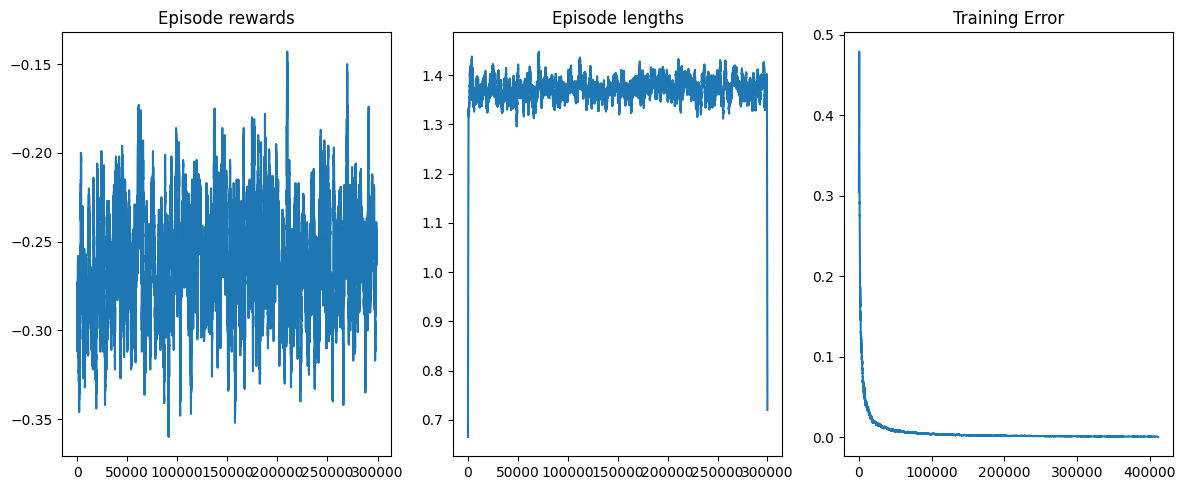

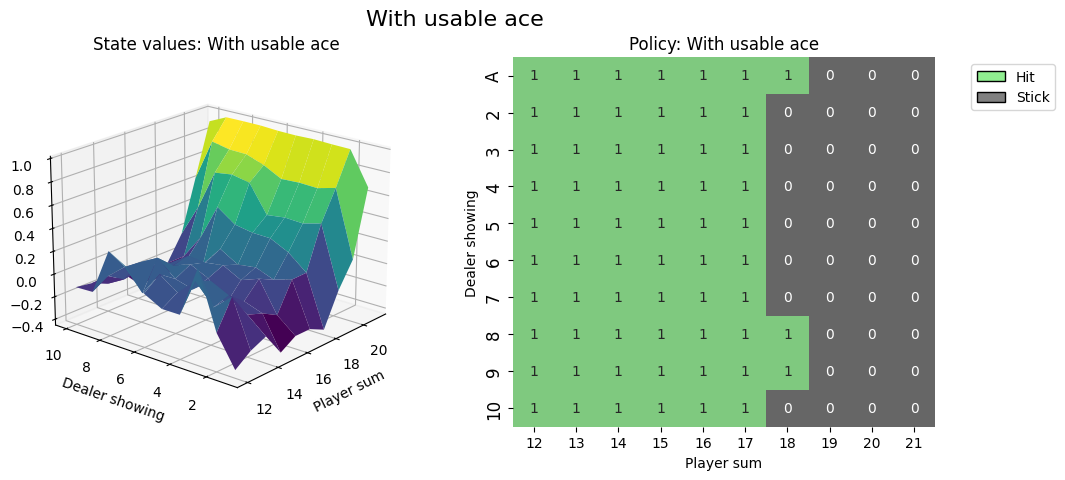

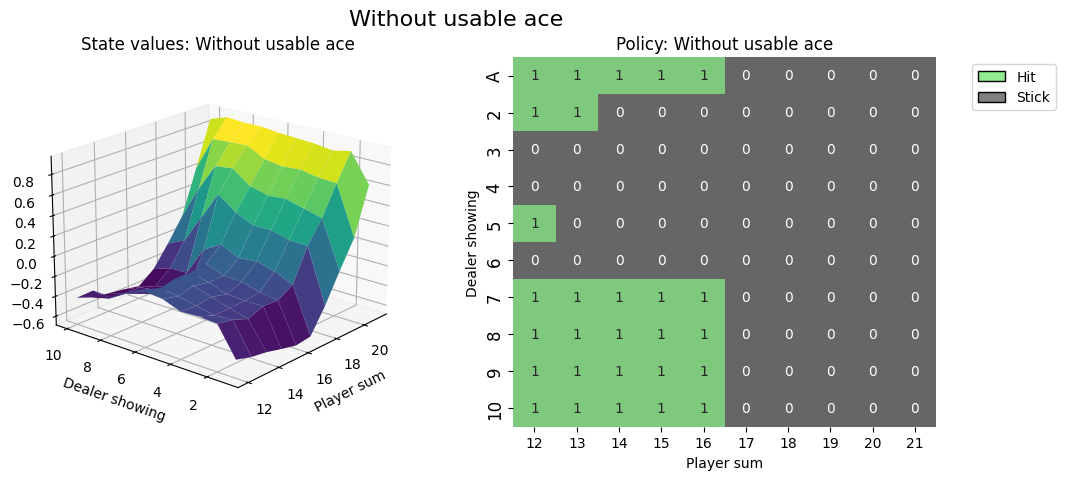


Entrenando agente 4/4: DQNAgent


Training DQNAgent: 100%|██████████| 300000/300000 [24:19<00:00, 205.51it/s]



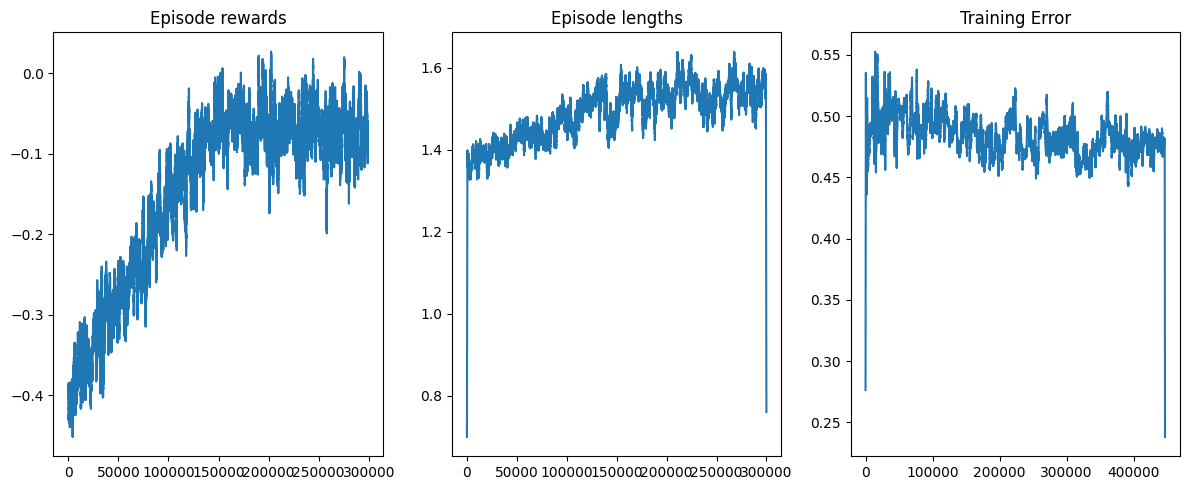

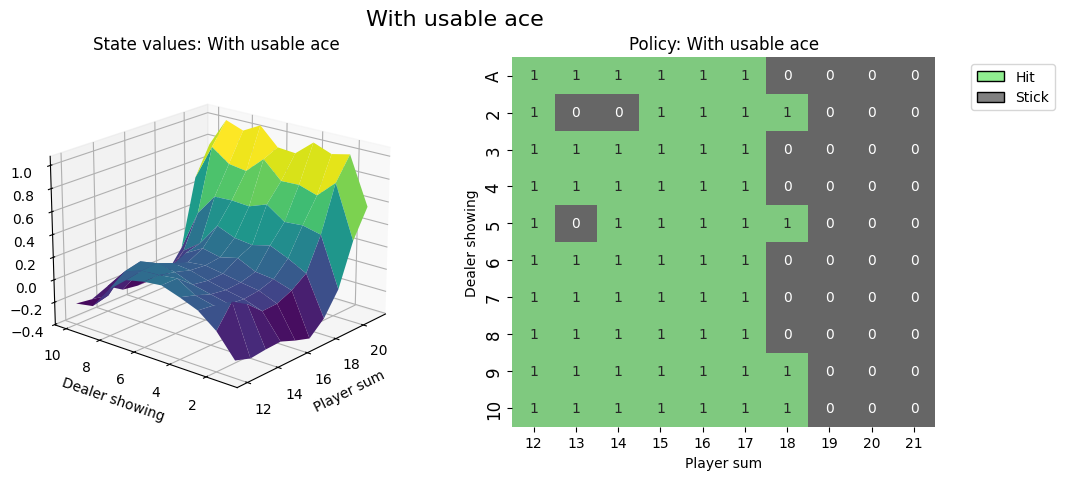

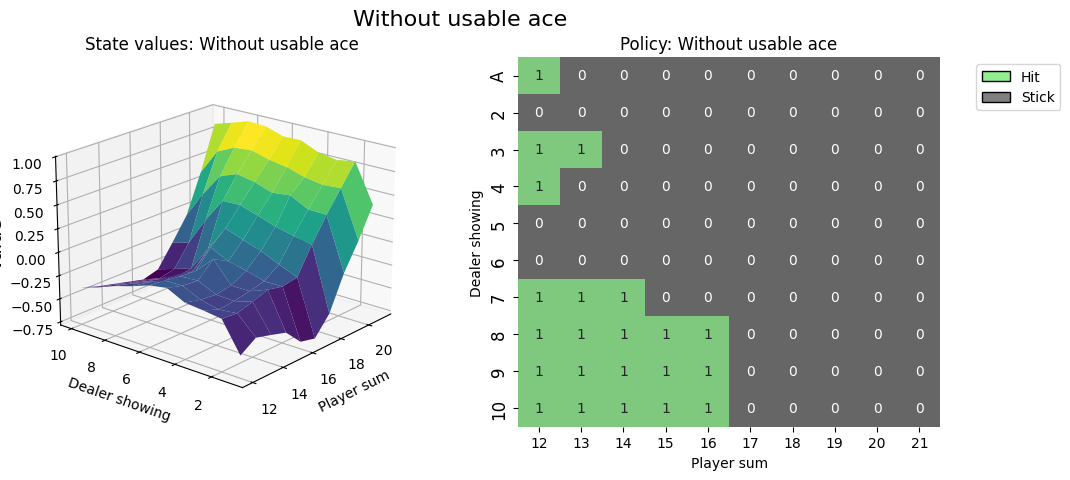


Entrenamiento completado para todos los agentes


In [ ]:
agent_environments = []

for i, agent in enumerate(agents):
    print(f"\n{'='*80}")
    print(f"Entrenando agente {i+1}/{len(agents)}: {agent.__class__.__name__}")
    print(f"{'='*80}")
    
    # Crear entorno independiente para este agente
    agent_env = make_env(cfg.n_episodes)
    
    # Determinar configuración según el tipo de agente
    agent_cfg = cfg_dqn if isinstance(agent, DQNAgent) else cfg
    
    # Entrenar
    train_agent(agent_env, agent, agent_cfg)
    
    # Guardar entorno con estadísticas
    agent_environments.append(agent_env)
    
    # Visualizar resultados
    plot_training(agent_env, agent)

    v_g, p_g = create_grids(agent, usable_ace=True)
    create_plots(v_g, p_g, "With usable ace")
    plt.show()

    v_g, p_g = create_grids(agent, usable_ace=False)
    create_plots(v_g, p_g, "Without usable ace")
    plt.show()

print(f"\n{'='*80}")
print("Entrenamiento completado para todos los agentes")
print(f"{'='*80}")

## Análisis de Resultados por Agente

In [ ]:
def calculate_metrics(agent, env, agent_name):
    """
    Calcula métricas completas de rendimiento para un agente entrenado.
    
    Returns:
        dict: Diccionario con todas las métricas calculadas
    """
    # Recompensas
    rewards = np.array(env.return_queue).flatten()
    last_1000_rewards = rewards[-1000:] if len(rewards) >= 1000 else rewards
    
    # Calcular tasas de victoria/derrota/empate
    wins = np.sum(last_1000_rewards == 1)
    losses = np.sum(last_1000_rewards == -1)
    draws = np.sum(last_1000_rewards == 0)
    total = len(last_1000_rewards)
    
    # Duración de episodios
    lengths = np.array(env.length_queue).flatten()
    last_1000_lengths = lengths[-1000:] if len(lengths) >= 1000 else lengths
    
    # Error de entrenamiento
    errors = np.array(agent.training_error)
    last_1000_errors = errors[-1000:] if len(errors) >= 1000 else errors
    
    # Convergencia
    convergence_threshold = 0.1
    convergence_episode = None
    if len(errors) > 1000:
        for i in range(1000, len(errors)):
            window = errors[i-1000:i]
            if np.mean(window) < convergence_threshold and np.std(window) < 0.05:
                convergence_episode = i
                break
    
    metrics = {
        'Agente': agent_name,
        'Recompensa Promedio': f"{np.mean(last_1000_rewards):.4f}",
        'Desviación Estándar': f"{np.std(last_1000_rewards):.4f}",
        'Recompensa Máxima': f"{np.max(rewards):.2f}",
        'Recompensa Mínima': f"{np.min(rewards):.2f}",
        'Tasa de Victoria (%)': f"{(wins/total)*100:.2f}",
        'Tasa de Derrota (%)': f"{(losses/total)*100:.2f}",
        'Tasa de Empate (%)': f"{(draws/total)*100:.2f}",
        'Error Final': f"{np.mean(last_1000_errors):.4f}",
        'Desv. Est. Error': f"{np.std(last_1000_errors):.4f}",
        'Estados Visitados': len(agent.q_values),
        'Cobertura Espacio (%)': f"{(len(agent.q_values)/280)*100:.2f}",
        'Duración Promedio Episodio': f"{np.mean(last_1000_lengths):.2f}",
        'Convergencia (episodio)': convergence_episode if convergence_episode else "No detectada",
    }
    
    return metrics

In [62]:
# Calcular métricas para todos los agentes usando sus entornos correspondientes
import pandas as pd

agent_names = ['TD Learning', 'Monte Carlo', 'Monte Carlo ES', 'DQN']
all_metrics = []

for agent, agent_env, name in zip(agents, agent_environments, agent_names):
    metrics = calculate_metrics(agent, agent_env, name)
    all_metrics.append(metrics)
    
# Crear DataFrame para visualización
df_metrics = pd.DataFrame(all_metrics)

# Mostrar tabla completa
print("="*100)
print("TABLA COMPARATIVA DE ALGORITMOS DE REINFORCEMENT LEARNING EN BLACKJACK")
print("="*100)
print(df_metrics.to_string(index=False))
print("="*100)

TABLA COMPARATIVA DE ALGORITMOS DE REINFORCEMENT LEARNING EN BLACKJACK
        Agente Recompensa Promedio Desviación Estándar Recompensa Máxima Recompensa Mínima Tasa de Victoria (%) Tasa de Derrota (%) Tasa de Empate (%) Error Final Desv. Est. Error  Estados Visitados Cobertura Espacio (%) Duración Promedio Episodio Convergencia (episodio)
   TD Learning             -0.0210              0.9595              1.00             -1.00                45.00               47.10               7.90      0.0308           0.7163                381                136.07                       1.47            No detectada
   Monte Carlo             -0.0700              0.9639              1.00             -1.00                43.20               50.20               6.60      0.0007           0.0012                281                100.36                       1.39                   16001
Monte Carlo ES             -0.2440              0.9436              1.00             -1.00                35.30  

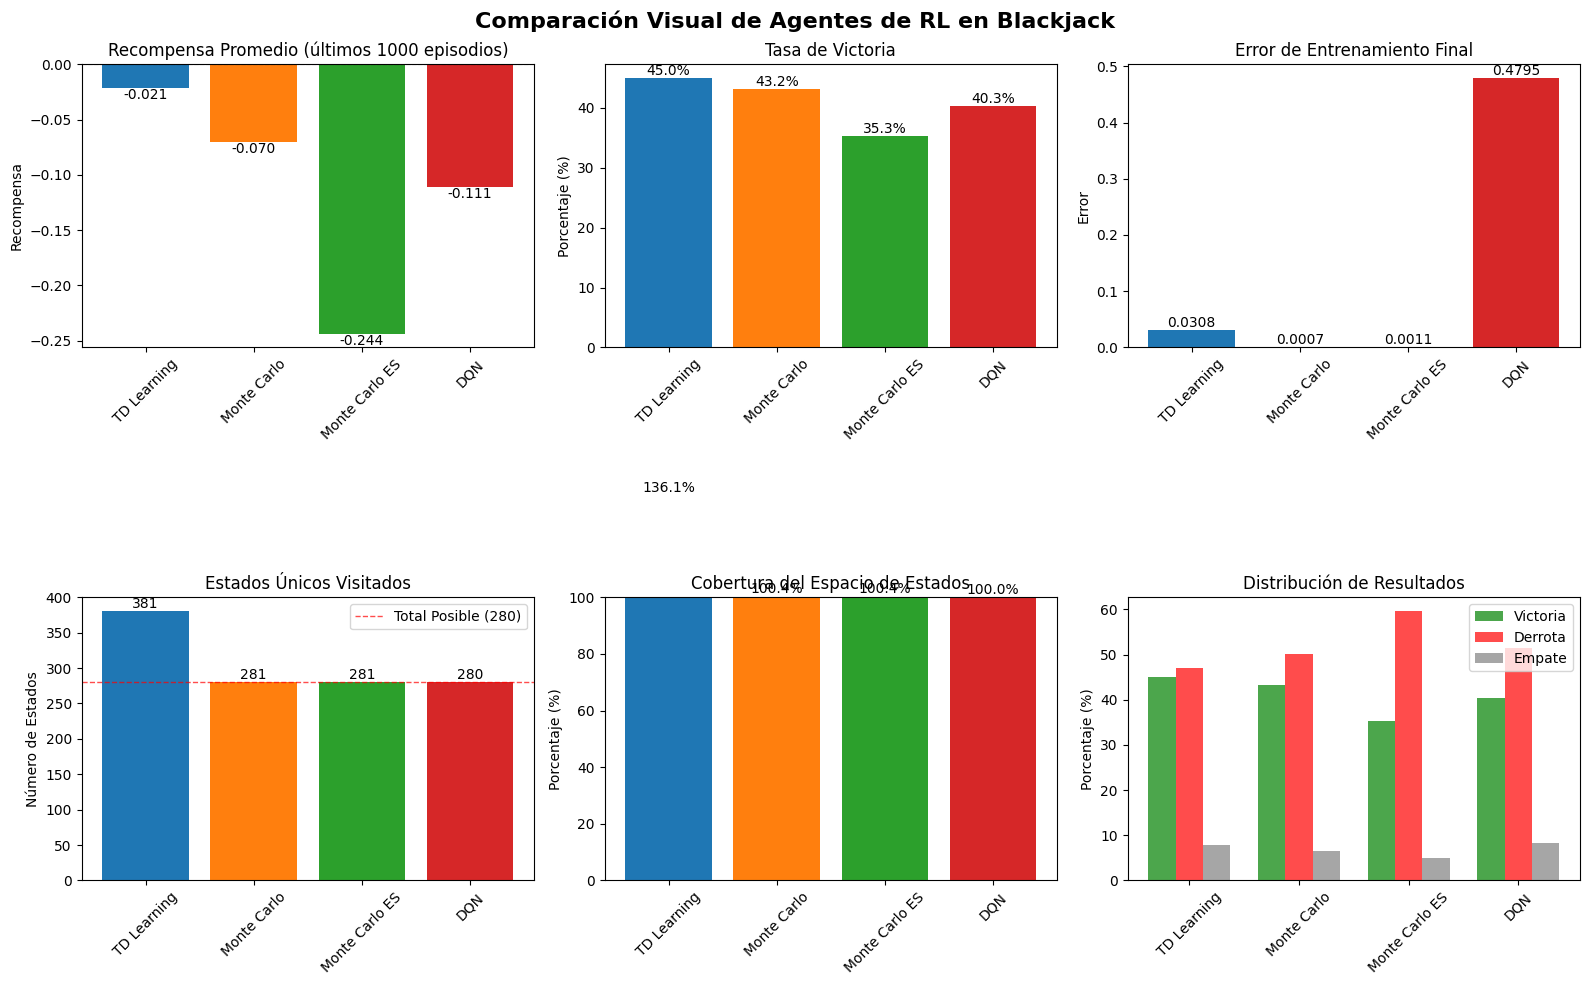

In [63]:
# Visualización gráfica de comparación
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
fig.suptitle('Comparación Visual de Agentes de RL en Blackjack', fontsize=16, fontweight='bold')

# 1. Recompensa Promedio
rewards_avg = [float(m['Recompensa Promedio']) for m in all_metrics]
axes[0, 0].bar(agent_names, rewards_avg, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
axes[0, 0].set_title('Recompensa Promedio (últimos 1000 episodios)')
axes[0, 0].set_ylabel('Recompensa')
axes[0, 0].axhline(y=0, color='black', linestyle='--', linewidth=0.8, alpha=0.5)
axes[0, 0].tick_params(axis='x', rotation=45)
for i, v in enumerate(rewards_avg):
    axes[0, 0].text(i, v, f'{v:.3f}', ha='center', va='bottom' if v > 0 else 'top')

# 2. Tasa de Victoria
win_rates = [float(m['Tasa de Victoria (%)']) for m in all_metrics]
axes[0, 1].bar(agent_names, win_rates, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
axes[0, 1].set_title('Tasa de Victoria')
axes[0, 1].set_ylabel('Porcentaje (%)')
axes[0, 1].tick_params(axis='x', rotation=45)
for i, v in enumerate(win_rates):
    axes[0, 1].text(i, v, f'{v:.1f}%', ha='center', va='bottom')

# 3. Error de Entrenamiento Final
errors = [float(m['Error Final']) for m in all_metrics]
axes[0, 2].bar(agent_names, errors, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
axes[0, 2].set_title('Error de Entrenamiento Final')
axes[0, 2].set_ylabel('Error')
axes[0, 2].tick_params(axis='x', rotation=45)
for i, v in enumerate(errors):
    axes[0, 2].text(i, v, f'{v:.4f}', ha='center', va='bottom')

# 4. Estados Visitados
states = [m['Estados Visitados'] for m in all_metrics]
axes[1, 0].bar(agent_names, states, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
axes[1, 0].set_title('Estados Únicos Visitados')
axes[1, 0].set_ylabel('Número de Estados')
axes[1, 0].axhline(y=280, color='red', linestyle='--', linewidth=1, alpha=0.7, label='Total Posible (280)')
axes[1, 0].legend()
axes[1, 0].tick_params(axis='x', rotation=45)
for i, v in enumerate(states):
    axes[1, 0].text(i, v, str(v), ha='center', va='bottom')

# 5. Cobertura del Espacio de Estados
coverage = [float(m['Cobertura Espacio (%)']) for m in all_metrics]
axes[1, 1].bar(agent_names, coverage, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
axes[1, 1].set_title('Cobertura del Espacio de Estados')
axes[1, 1].set_ylabel('Porcentaje (%)')
axes[1, 1].set_ylim([0, 100])
axes[1, 1].tick_params(axis='x', rotation=45)
for i, v in enumerate(coverage):
    axes[1, 1].text(i, v, f'{v:.1f}%', ha='center', va='bottom')

# 6. Distribución de Resultados (Win/Loss/Draw)
win_rates_plot = [float(m['Tasa de Victoria (%)']) for m in all_metrics]
loss_rates = [float(m['Tasa de Derrota (%)']) for m in all_metrics]
draw_rates = [float(m['Tasa de Empate (%)']) for m in all_metrics]

x = np.arange(len(agent_names))
width = 0.25

axes[1, 2].bar(x - width, win_rates_plot, width, label='Victoria', color='green', alpha=0.7)
axes[1, 2].bar(x, loss_rates, width, label='Derrota', color='red', alpha=0.7)
axes[1, 2].bar(x + width, draw_rates, width, label='Empate', color='gray', alpha=0.7)
axes[1, 2].set_title('Distribución de Resultados')
axes[1, 2].set_ylabel('Porcentaje (%)')
axes[1, 2].set_xticks(x)
axes[1, 2].set_xticklabels(agent_names, rotation=45)
axes[1, 2].legend()

plt.tight_layout()
plt.show()

In [69]:
# Guardar tabla en formato CSV para usar en informes
df_metrics.to_csv('comparacion_agentes_rl.csv', index=False)
print("Tabla guardada en 'comparacion_agentes_rl.csv'")

# También crear una tabla más compacta para el informe
df_compact = df_metrics[['Agente', 'Recompensa Promedio', 'Tasa de Victoria (%)', 
                          'Error Final', 'Estados Visitados', 'Cobertura Espacio (%)']]

print("\n" + "="*80)
print("TABLA COMPACTA")
print("="*80)
print(df_compact.to_string(index=False))
print("="*80)

Tabla guardada en 'comparacion_agentes_rl.csv'

TABLA COMPACTA
        Agente Recompensa Promedio Tasa de Victoria (%) Error Final  Estados Visitados Cobertura Espacio (%)
   TD Learning             -0.0210                45.00      0.0308                381                136.07
   Monte Carlo             -0.0700                43.20      0.0007                281                100.36
Monte Carlo ES             -0.2440                35.30      0.0011                281                100.36
           DQN             -0.1110                40.30      0.4795                280                100.00


## Análisis de Resultados

### Interpretación de Métricas:

**Recompensa Promedio**: Valor entre -1 y 1 que indica el desempeño general. Valores cercanos a 0 o positivos son buenos para Blackjack.

**Tasa de Victoria**: Porcentaje de episodios ganados en los últimos 1000 episodios. Valores típicos están entre 40-45%.

**Error de Entrenamiento**: Magnitud de las correcciones en los valores Q. Valores bajos indican convergencia.

**Estados Visitados**: Número de estados únicos explorados (espacio: ~280).

**Cobertura del Espacio**: Porcentaje del espacio de estados explorado durante el entrenamiento.